In [ ]:
import pandas as pd

_df = pd.read_csv("https://gist.githubusercontent.com/mevangelista-alvarado/6f4f28c00f9e683108637cb3c8d5db89/raw/1ce753283fce23eeab952fa1d660a7069bbe9104/Bitcoin_1_1_2024-6_9_2024_historical_data_coinmarketcap.csv", delimiter=';')
# Ordenamos correctamente
_df = _df.sort_index(ascending=False)
_df.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
158,2024-01-03T00:00:00.000Z,2024-01-03T23:59:59.999Z,2024-01-03T09:40:00.000Z,2024-01-03T12:10:00.000Z,2781,44961.603187,45503.241795,40813.534868,42848.175641,4.634232e+10,8.393459e+11,2024-01-03T23:59:59.999Z
157,2024-01-04T00:00:00.000Z,2024-01-04T23:59:59.999Z,2024-01-04T22:22:00.000Z,2024-01-04T01:26:00.000Z,2781,42855.814761,44770.023414,42675.174007,44179.921701,3.044809e+10,8.654825e+11,2024-01-04T23:59:59.999Z
156,2024-01-05T00:00:00.000Z,2024-01-05T23:59:59.999Z,2024-01-05T23:07:00.000Z,2024-01-05T01:49:00.000Z,2781,44192.978699,44353.285859,42784.718266,44162.691630,3.233603e+10,8.651827e+11,2024-01-05T23:59:59.999Z
155,2024-01-06T00:00:00.000Z,2024-01-06T23:59:59.999Z,2024-01-06T00:10:00.000Z,2024-01-06T07:07:00.000Z,2781,44178.954607,44227.631307,43475.156431,43989.194093,1.609250e+10,8.618220e+11,2024-01-06T23:59:59.999Z
154,2024-01-07T00:00:00.000Z,2024-01-07T23:59:59.999Z,2024-01-07T14:09:00.000Z,2024-01-07T23:45:00.000Z,2781,43998.464243,44495.571471,43662.228627,43943.097229,1.933057e+10,8.609518e+11,2024-01-07T23:59:59.999Z


In [ ]:
df = _df[['timeOpen', 'open', 'high', 'low', 'close']]

In [ ]:
dates = df[['close']].values  # Seleccionamos la columna "close" como DataFrame y la convertimos en un arreglo de NumPy.


In [ ]:
# Escalamos los datos
from sklearn.preprocessing import MinMaxScaler

# Creamos un objeto MinMaxScaler para normalizar los valores entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustamos el scaler a los datos y transformamos la columna "close"
# Esto convierte los valores originales a un rango entre 0 y 1
scaled_data = scaler.fit_transform(dates)


In [ ]:
window_size = 60  # Tamaño de la ventana: número de datos anteriores que usará el modelo para predecir el siguiente valor


In [ ]:
import numpy as np

# Función para crear secuencias de datos basadas en una ventana deslizante
def create_sequences(data, window_size):
    sequences = []  # Aquí guardaremos las secuencias de entrada
    labels = []     # Aquí guardaremos el valor objetivo (y)

    # Recorremos los datos hasta el punto en que aún se pueda formar una ventana completa
    for i in range(len(data) - window_size):

        # Tomamos una ventana de 'window_size' valores consecutivos
        sequences.append(data[i:i + window_size])

        # El valor a predecir es el que está justo después de la ventana
        # data[i + window_size] → siguiente dato
        # [0] → primera columna (ej. "close")
        labels.append(data[i + window_size, 0])

    # Convertimos las listas a arreglos NumPy
    return np.array(sequences), np.array(labels)

# Generamos las secuencias X (entradas) y y (etiquetas)
X, y = create_sequences(scaled_data, window_size)


In [ ]:
# Definimos el punto de división: 80% para entrenamiento y 20% para prueba
split = int(len(X) * 0.8)

# Conjunto de entrenamiento: desde el inicio hasta el 80%
X_train, y_train = X[:split], y[:split]

# Conjunto de prueba: el 20% restante
X_test, y_test = X[split:], y[split:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN

# Construimos un modelo secuencial para series temporales
model = Sequential()

# Primera capa RNN:
# - 120 unidades
# - return_sequences=True para devolver toda la secuencia (necesario porque habrá otra capa RNN después)
# - input_shape define el tamaño de la ventana y el número de características
model.add(SimpleRNN(units=120, return_sequences=True,
                    input_shape=(window_size, X_train.shape[2])))

# Segunda capa RNN:
# - 60 unidades
# - return_sequences=False porque esta será la última capa RNN
model.add(SimpleRNN(units=60, return_sequences=False))

# Capa densa intermedia con 30 neuronas para procesar las características extraídas
model.add(Dense(units=30))

# Capa de salida con 1 neurona (predicción del siguiente valor)
model.add(Dense(units=1))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Definimos la tasa de aprendizaje para el optimizador
learning_rate = 0.001

# Creamos el optimizador Adam con esa tasa de aprendizaje
adam_optimizer = Adam(learning_rate=learning_rate)

# Compilamos el modelo:
# - optimizer: Adam, que ajustará los pesos durante el entrenamiento
# - loss: usamos el error cuadrático medio (MSE), común en regresión
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Entrenamos el modelo:
# - X_train, y_train → datos de entrenamiento
# - batch_size=1 → se actualizan los pesos después de cada muestra
# - epochs=10 → el modelo verá los datos completos 10 veces
model.fit(X_train, y_train, batch_size=1, epochs=10)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3293
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0157
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0160
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0139
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0058
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0106
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0114
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0088
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0181
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0102


In [ ]:
# Hacer predicciones con el modelo usando el conjunto de prueba
predictions = model.predict(X_test)

# Para desescalar, el MinMaxScaler espera el mismo número de columnas que tenía originalmente.
# Como solo usamos la columna "close", recreamos columnas ficticias (3 columnas de ceros).
# Luego aplicamos inverse_transform y tomamos solo la primera columna (la real).
predictions = scaler.inverse_transform(
    np.concatenate((predictions, np.zeros((predictions.shape[0], 3))), axis=1)
)[:, 0]

# Lo mismo para los valores reales (y_test), que deben tener forma (n, 1)
y_test = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))), axis=1)
)[:, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculamos el MAE (Mean Absolute Error):
# Promedio de las diferencias absolutas entre valores reales y predicciones.
mae = mean_absolute_error(y_test, predictions)

# Calculamos el RMSE (Root Mean Squared Error):
# Raíz cuadrada del error cuadrático medio. Penaliza más los errores grandes.
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Mostramos las métricas de evaluación del modelo
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 2337.2801938097978
RMSE: 2633.8107944412777


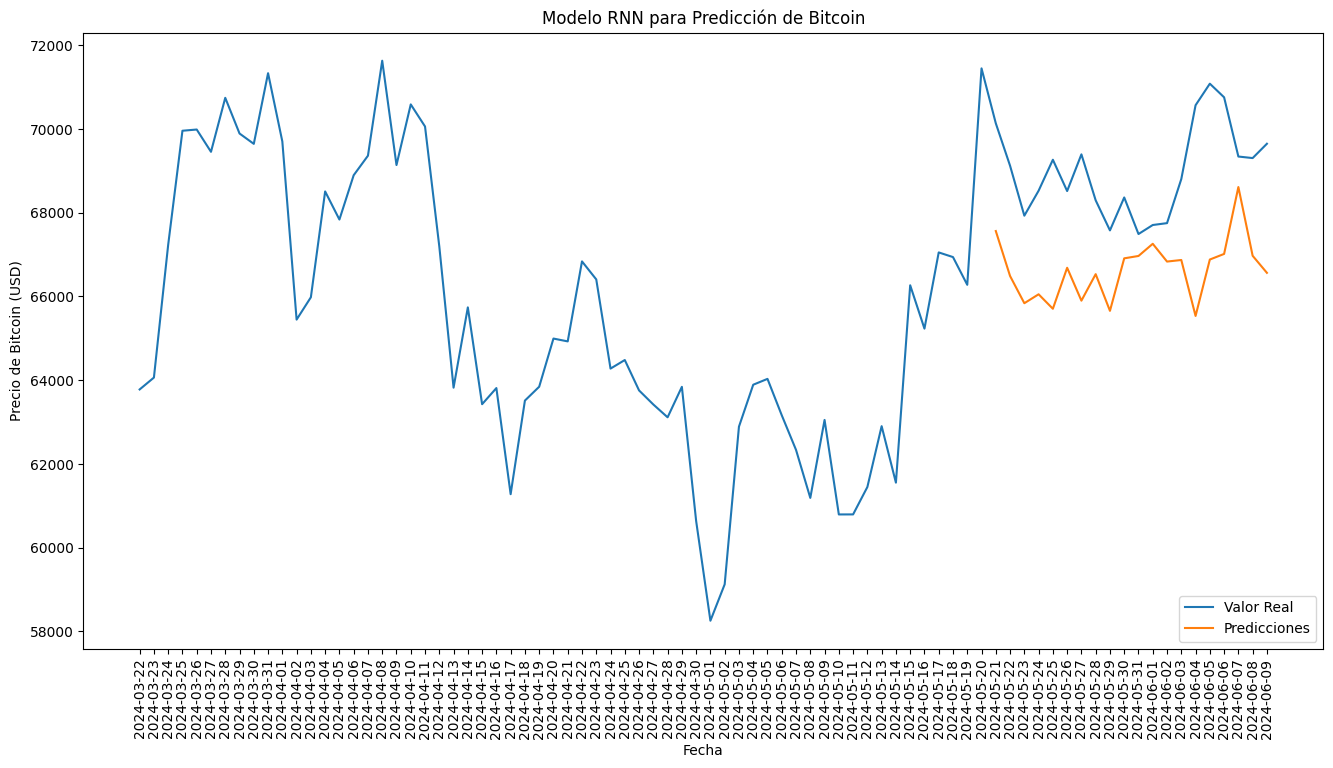

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extraemos del DataFrame original solo el 20% final (conjunto de prueba)
valid = df[split:]

# Reiniciamos el índice para que empiece desde 0
valid = valid.reset_index(drop=True)

# Creamos una nueva columna llamada "Predictions" rellena con NaN
# para luego colocar ahí las predicciones desescaladas
valid['Predictions'] = np.nan

# Insertamos las predicciones a partir del índice igual a window_size
# porque las primeras 'window_size' posiciones no tienen predicción (necesitan datos previos)
valid.loc[window_size:, 'Predictions'] = predictions

# Convertimos la columna de fechas a formato YYYY-MM-DD
dates_valid = pd.to_datetime(valid['timeOpen']).apply(lambda x: x.strftime('%Y-%m-%d')).tolist()

# Configuramos la figura del gráfico
plt.figure(figsize=(16,8))
plt.title('Modelo RNN para Predicción de Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin (USD)')

# Trazamos los valores reales y las predicciones
plt.plot(dates_valid, valid[['close', 'Predictions']])

# Agregamos leyenda al gráfico
plt.legend(['Valor Real', 'Predicciones'], loc='lower right')

# Rotamos las etiquetas del eje X para mejor lectura
plt.xticks(rotation=90)

# Mostramos el gráfico
plt.show()


In [ ]:
# Generar secuencias para predecir los próximos días

future_sequences = []

# Tomamos la última secuencia disponible del conjunto X
# (la secuencia más reciente que el modelo ya conoce)
last_sequence = X[-1]

# Número de días que queremos predecir hacia adelante
days = 10

for _ in range(days):
    # Predecimos el siguiente valor a partir de la última secuencia conocida
    next_value = model.predict(np.array([last_sequence]))[0, 0]

    # Actualizamos la secuencia:
    # - Eliminamos el primer valor
    # - Agregamos al final la predicción recién obtenida
    # Esto permite hacer predicciones autoregresivas (una predicción alimenta a la siguiente)
    last_sequence = np.concatenate((last_sequence[1:], [[next_value]]), axis=0)

    # Guardamos la nueva secuencia para usarla luego en la RNN
    future_sequences.append(last_sequence)

# Convertimos la lista en un arreglo NumPy
future_sequences = np.array(future_sequences)

# Ajustamos la forma (num_días, window_size, num_features)
future_sequences = np.reshape(
    future_sequences,
    (future_sequences.shape[0], future_sequences.shape[1], 1)
)

# Hacemos las predicciones para los días futuros
future_predictions = model.predict(future_sequences)

# Desescalamos las predicciones usando el mismo truco que antes,
# añadiendo columnas de ceros para coincidir con la dimensión original del scaler
future_predictions = scaler.inverse_transform(
    np.concatenate((future_predictions, np.zeros((future_predictions.shape[0], 3))), axis=1)
)[:, 0]



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [ ]:
# Obtener la última fecha disponible en los datos reales
last_date = df['timeOpen'].iloc[-1]

# Generar un rango de fechas a partir de la última fecha
# periods=days genera 'days' fechas hacia adelante (incluye la fecha inicial)
future_dates = pd.date_range(start=last_date, periods=days)[1:]

# Convertir las fechas al formato YYYY-MM-DD para graficarlas o mostrarlas
future_dates = future_dates.strftime('%Y-%m-%d').tolist()


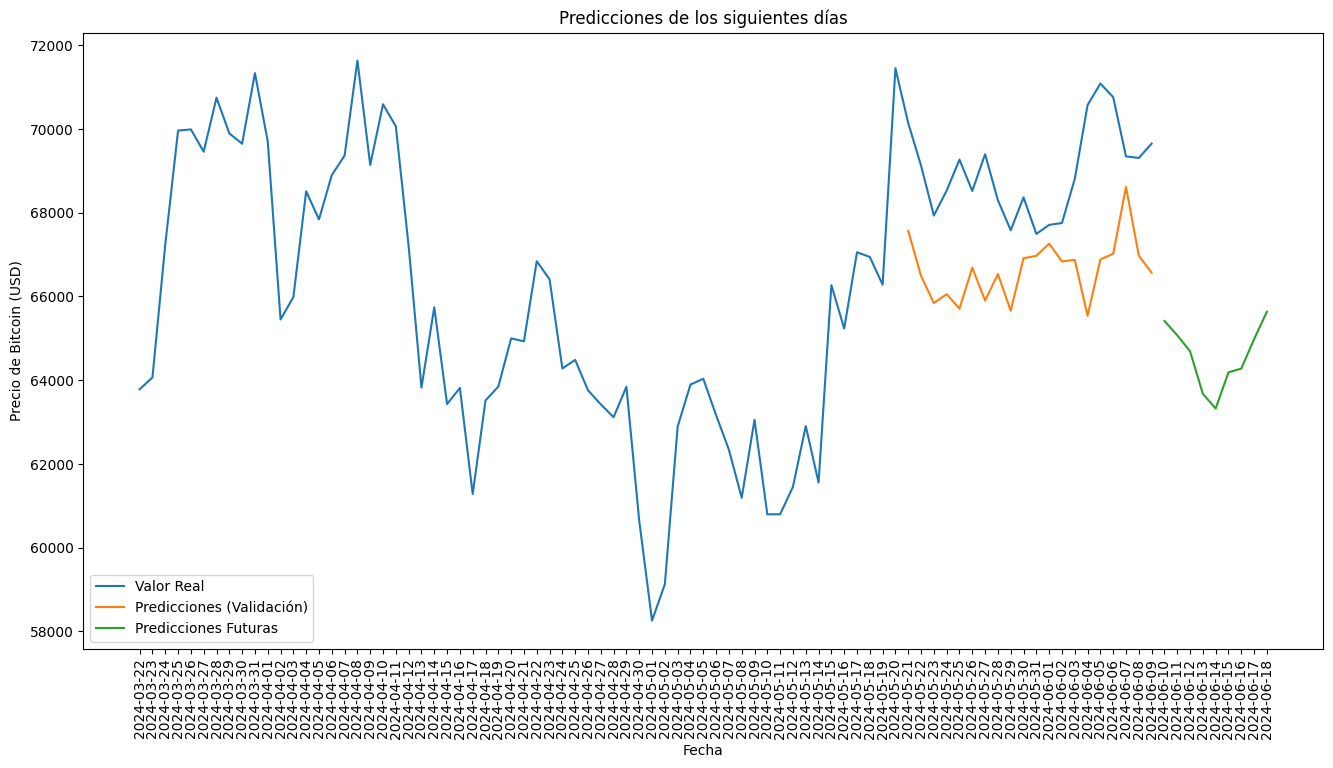

In [ ]:
# Gráfico de predicciones reales y futuras

plt.figure(figsize=(16, 8))
plt.title('Predicciones de los siguientes días')
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin (USD)')

# Línea de valores reales
plt.plot(dates_valid, valid['close'], label='Valor Real')

# Línea de predicciones del modelo sobre el conjunto de validación
plt.plot(dates_valid, valid['Predictions'], label='Predicciones (Validación)')

# Línea de predicciones futuras
# future_predictions[:-1] se usa porque se generaron 'days' fechas,
# pero la primera fecha es la misma que last_date
plt.plot(future_dates, future_predictions[:-1], label='Predicciones Futuras')

plt.legend()
plt.xticks(rotation=90)
plt.show()
